## Frequency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from tqdm.notebook import tqdm
from parfor import parfor
import matplotlib.colors as colors

In [2]:
@njit()
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n,len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y
args = ()
@njit()
def H_Chimera(u,t=0,args = args):
    r1 = u[0]
    r2 = u[1]
    phi = u[2]
    beta,alpha,eta1,eta2 = args
    dr1 = 1/2 * r1* (1-r1**2)*(eta1**2 * r1**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r1*r2*np.cos(alpha+phi) + beta**2 * eta2**2 * r2**2 * np.cos(alpha + 2*phi))
    dr2 = 1/2 * r2* (1-r2**2)*(eta2**2 * r2**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r2*r1*np.cos(alpha-phi) + beta**2 * eta1**2 * r1**2 * np.cos(alpha - 2*phi))
    dpsi1 = -1/2 * (1+r1**2)*(eta1**2 * r1**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r1*r2*np.sin(alpha+phi) + beta**2 * eta2**2 * r2**2 * np.sin(alpha + 2*phi))
    dpsi2 = -1/2 * (1+r2**2)*(eta2**2 * r2**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r2*r1*np.sin(alpha-phi) + beta**2 * eta1**2 * r1**2 * np.sin(alpha - 2*phi))
    dphi = dpsi1 - dpsi2
    return np.array([dr1,dr2,dphi])



def myFun2(u,t=0,args = args):
    r = u[0]
    phi = u[1]
    beta,alpha,eta1,eta2 = args
    dr = 1/2 * r* (1-r**2)*(eta2**2 * r**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r*np.cos(alpha+phi) + beta**2 * eta1**2 * np.cos(alpha + 2*phi))
    dpsi2 = -1/2 * (1+r**2)*(eta2**2 * r**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r*np.sin(alpha+phi) + beta**2 * eta1**2 * np.sin(alpha + 2*phi))
    dpsi1 = -1/2 * (2)*(eta1**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r *np.sin(alpha-phi) + beta**2 * eta2**2 * r**2 * np.sin(alpha-2*phi))
    dphi =  dpsi2 - dpsi1
    return np.array([dr,dphi])


In [19]:

alpha = 1
beta = 0.9
eta1 = 0.8
eta2 = 0.4

args = beta,alpha,eta1,eta2
t = np.arange(0,50_000,0.1)
y = np.linspace(0,0,1)
x = np.linspace(0,2*np.pi,5)
X,Y = np.meshgrid(x,y)
fx = 0.5
fy = 0.5

In [20]:
u0 = [1,0.6,0]
alphas = np.linspace(0,np.pi/2,51)[:-1]
betas = np.linspace(0,1,51)
BE,AL =np.meshgrid(betas,alphas)
BAs = list(zip(AL.flatten(),BE.flatten()))

In [21]:
betas

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [22]:
AL.flatten().reshape(AL.shape)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03141593, 0.03141593, 0.03141593, ..., 0.03141593, 0.03141593,
        0.03141593],
       [0.06283185, 0.06283185, 0.06283185, ..., 0.06283185, 0.06283185,
        0.06283185],
       ...,
       [1.47654855, 1.47654855, 1.47654855, ..., 1.47654855, 1.47654855,
        1.47654855],
       [1.50796447, 1.50796447, 1.50796447, ..., 1.50796447, 1.50796447,
        1.50796447],
       [1.5393804 , 1.5393804 , 1.5393804 , ..., 1.5393804 , 1.5393804 ,
        1.5393804 ]])

In [23]:
t[200_000]

20000.0

In [27]:
@parfor(BAs,args=(eta1,eta2))
def get(BA,eta1,eta2):
    alpha,beta = BA
    args = beta,alpha,eta1,eta2
    R2,R,phi = RK4(H_Chimera,np.array(u0,dtype=float),t,args=(args,))[-200_000:].T
    n_freq, = np.where(np.diff(phi//(np.pi*2)))
    T = np.mean(np.diff(n_freq))*0.1
    return R2[-1],R[-1],T

  0%|          | 0/2550 [00:00<?, ?it/s]

In [33]:
R1S,RS,TS = map(np.array,zip(*get))

In [34]:
RR1 = R1S.reshape(AL.shape)
RR = RS.reshape(AL.shape)
TT = TS.reshape(AL.shape)

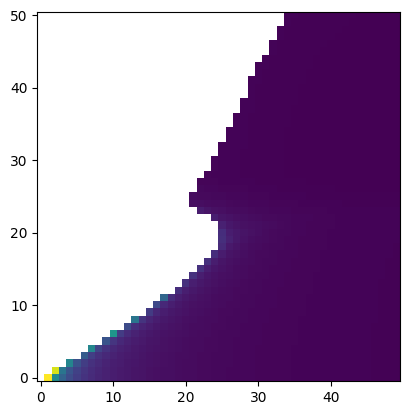

In [35]:
plt.imshow(TT.T,origin='lower')

In [38]:
np.max(1-RR**2)

0.9998833317792286

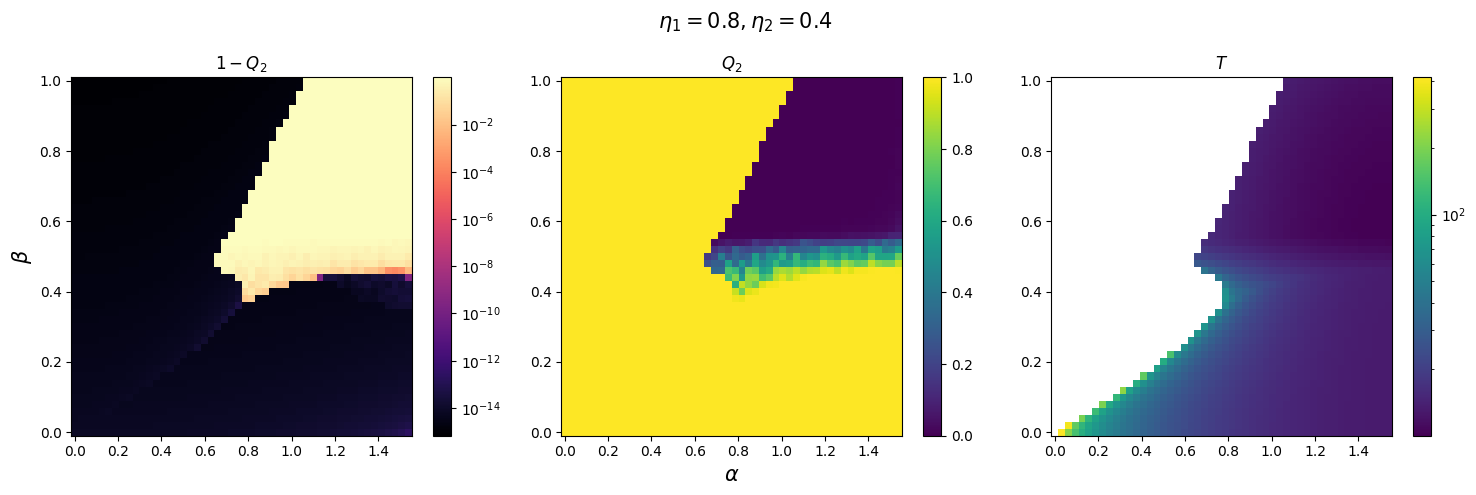

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.pcolormesh(AL,BE,1-RR**2,cmap='magma',norm=colors.LogNorm())
plt.title(rf'$1-Q_2$')
plt.ylabel(r'$\beta$',fontsize=15)
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(AL,BE,RR**2,vmin=0,vmax=1)
plt.title(rf'$Q_2$')
plt.xlabel(r'$\alpha$',fontsize=15)

plt.colorbar()
plt.subplot(133)
plt.pcolormesh(AL,BE,TT,norm=colors.LogNorm())
plt.title(rf'$T$')

plt.colorbar()
plt.suptitle(rf'$\eta_1={eta1},\eta_2={eta2}$',fontsize=15)
plt.tight_layout()

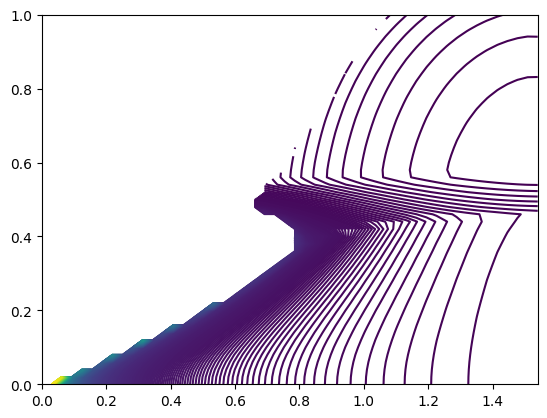

In [46]:
plt.contour(AL,BE,TT,levels=1000)


In [34]:
AL[:,1], BE[:,1]

(array([0.        , 0.03141593, 0.06283185, 0.09424778, 0.12566371,
        0.15707963, 0.18849556, 0.21991149, 0.25132741, 0.28274334,
        0.31415927, 0.34557519, 0.37699112, 0.40840704, 0.43982297,
        0.4712389 , 0.50265482, 0.53407075, 0.56548668, 0.5969026 ,
        0.62831853, 0.65973446, 0.69115038, 0.72256631, 0.75398224,
        0.78539816, 0.81681409, 0.84823002, 0.87964594, 0.91106187,
        0.9424778 , 0.97389372, 1.00530965, 1.03672558, 1.0681415 ,
        1.09955743, 1.13097336, 1.16238928, 1.19380521, 1.22522113,
        1.25663706, 1.28805299, 1.31946891, 1.35088484, 1.38230077,
        1.41371669, 1.44513262, 1.47654855, 1.50796447, 1.5393804 ]),
 array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
        0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
        0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
        0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
        0.02, 0.02, 0.

In [13]:
fig,axs = plt.subplots(5,11,figsize=(20,15),sharex=True,sharey=True,dpi=500)
ax_ = axs.flatten()
for i,beta in enumerate(betas):
    plt.sca(ax_[i])
    plt.plot(AL[:,i],TT[:,i])
    plt.xlabel(r'$\alpha$',fontsize=15)
    plt.ylabel(r'$T$',fontsize=15)
    plt.title(rf'$\beta = {beta:.02f}$')
    # plt.loglog()
    # plt.grid()
plt.xlabel(r'$\beta$',fontsize=15)
plt.ylabel(r'$T$',fontsize=15)
# plt.yscale('log')
plt.tight_layout()

Text(0, 0.5, '$T$')

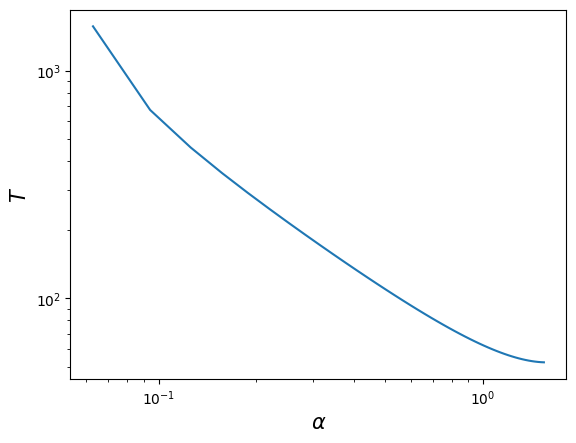

In [14]:
plt.plot(AL[:,1],TT[:,1])
plt.loglog()
plt.xlabel(r'$\alpha$',fontsize=15)
plt.ylabel(r'$T$',fontsize=15)
# plt.yscale('log')

In [15]:
len(betas)

51

In [16]:
BE[1,:]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [17]:
fig,axs = plt.subplots(5,11,figsize=(20,15),sharex=True,sharey=True,dpi=500)
ax_ = axs.flatten()
for i,alpha in enumerate(alphas):
    plt.sca(ax_[i])
    plt.plot(BE[i,:],TT[i,:])
    plt.xlabel(r'$\beta$',fontsize=15)
    plt.ylabel(r'$T$',fontsize=15)
    plt.title(rf'$\alpha = {alpha/np.pi:.02f}\pi$')
# plt.loglog()
plt.xlabel(r'$\beta$',fontsize=15)
plt.ylabel(r'$T$',fontsize=15)
# plt.yscale('log')
plt.tight_layout()

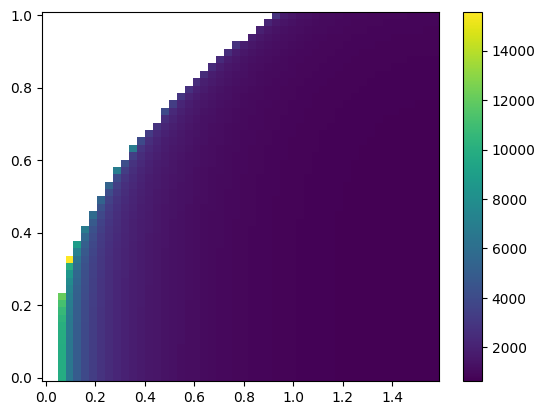

In [332]:
plt.pcolormesh(AL,BE,TT)
plt.colorbar()

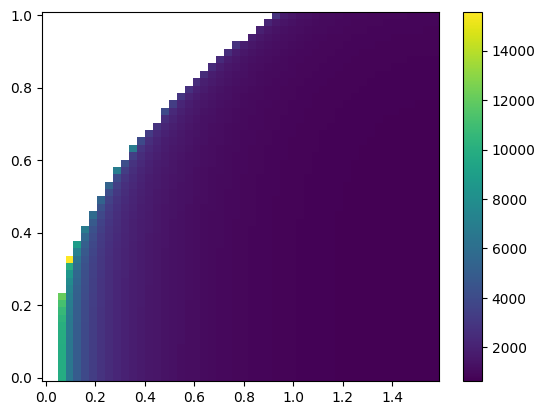

In [326]:
plt.pcolormesh(AL,BE,TT)
plt.colorbar()

In [297]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

In [298]:
# alpha,phi,B = np.symbols('alpha phi B',real = True)
# eta1 = 0.1
# eta2 = 0.05
# alpha = 0.1
B = (eta1/eta2)**2
phi = np.linspace(0,2*np.pi,1000)

In [166]:
def APM(phi,alpha,sign = 1):
    Apm = np.cos(alpha+phi) + sign*np.sin(phi)
    return Apm


def get_R_phi0(phi,alpha,eta1,eta2,APM=APM,sign=1,R_sign=1):
    Apm = APM(phi,alpha,sign)
    B = (eta1/eta2)**2
    A1 = np.sin(alpha)*np.cos(alpha+2*phi)**2
    Apm = np.cos(alpha+phi) + np.abs(np.sin(phi))
    CP = Apm**2 * np.sin(alpha + 2*phi) - 2*Apm*np.sin(alpha+phi)*np.cos(alpha+2*phi) + A1
    DP = CP - 2* Apm**2 * np.sin(alpha-2*phi)/B
    EP = CP + 4*Apm*np.sin(alpha - phi) *np.cos(alpha + 2*phi)
    R1 = np.sqrt((-EP + R_sign*np.sqrt(EP**2 + 8*DP*B*A1))/(2*DP))
    return R1


def get_R_Det0(phi,alpha,eta1,eta2,APM=APM,sign=1,R_sign=1):
    Apm = APM(phi,alpha,sign)
    B = eta1/eta2
    # Apm = np.cos(alpha+phi) + (np.sin(phi))
    SA = np.sin(alpha)
    CA = np.cos(alpha)
    SA_P1P = np.sin(alpha + phi)
    SA_P2P = np.sin(alpha +2*phi)
    CA_P1P = np.cos(alpha + phi)
    CA_P2P = np.cos(alpha +2*phi)
    SA_M1P = np.sin(alpha -phi)
    SA_M2P = np.sin(alpha -2*phi)
    CA_M1P = np.cos(alpha -phi)
    CA_M2P = np.cos(alpha -2*phi)

    A_DDA3 = 4*B**2*SA_P2P**2 + 6*B**2*CA_P2P**2 - 8*SA_M2P*SA_P2P + 12*CA_M2P*CA_P2P
    A_DDA2 = -16*B**2*SA_P1P*SA_P2P*CA_P2P - 22*B**2*CA_P1P*CA_P2P**2 + 8*SA_M2P*SA_P1P*CA_P2P - 32*CA_M2P*CA_P1P*CA_P2P
    A_DDA1 = 8*B**2*SA*SA_P2P*CA_P2P**2 + 12*B**2*SA_P1P**2*CA_P2P**2 + 10*B**2*CA*CA_P2P**3 + 16*B**2*CA_P1P**2*CA_P2P**2 + 20*CA*CA_M2P*CA_P2P**2
    A_DD0 = B**2*(-8*SA*SA_P1P*CA_P2P**3 - 10*CA*CA_P1P*CA_P2P**3)
    B_DDA3 = B**2*(-SA_P2P**2 + CA_P2P**2) + 2*SA_M2P*SA_P2P - CA_M2P*CA_P2P
    B_DDA2 = B**2*(2*SA_M1P*SA_P2P*CA_P2P + 3*SA_P1P*SA_P2P*CA_P2P - 3*CA_M1P*CA_P2P**2 - 3*CA_P1P*CA_P2P**2) - 2*SA_M2P*SA_P1P*CA_P2P + 4*CA_M2P*CA_P1P*CA_P2P
    B_DDA1 = B**2*(-SA*SA_P2P*CA_P2P**2 - 2*SA_M1P*SA_P1P*CA_P2P**2 - 2*SA_P1P**2*CA_P2P**2 + CA*CA_P2P**3 + 8*CA_M1P*CA_P1P*CA_P2P**2 + 2*CA_P1P**2*CA_P2P**2) - 3*CA*CA_M2P*CA_P2P**2
    B_DD0 = B**2*(SA*SA_P1P*CA_P2P**3 - 5*CA*CA_M1P*CA_P2P**3 - CA*CA_P1P*CA_P2P**3)
    C_DDA3 = -2*CA_P2P**2
    C_DDA2 = -8*SA_M1P*SA_P2P*CA_P2P + 4*SA_P1P*SA_P2P*CA_P2P + 4*CA_M1P*CA_P2P**2 + 10*CA_P1P*CA_P2P**2
    C_DDA1 = -4*SA*SA_P2P*CA_P2P**2 + 8*SA_M1P*SA_P1P*CA_P2P**2 - 4*SA_P1P**2*CA_P2P**2 - 6*CA*CA_P2P**3 - 16*CA_M1P*CA_P1P*CA_P2P**2 - 8*CA_P1P**2*CA_P2P**2
    C_DD0 = 4*SA*SA_P1P*CA_P2P**3 + 12*CA*CA_M1P*CA_P2P**3 + 6*CA*CA_P1P*CA_P2P**3
    A_Delta = A_DD0 + A_DDA3*Apm**3 + A_DDA2*Apm**2 + A_DDA1*Apm
    B_Delta = (B_DD0 + B_DDA3*Apm**3 + B_DDA2*Apm**2 + B_DDA1*Apm)*2
    C_Delta = (C_DD0 + C_DDA3*Apm**3 + C_DDA2*Apm**2 + C_DDA1*Apm)*B**2

    R1_DET = np.sqrt(-B_Delta/A_Delta +R_sign * np.sqrt(-A_Delta*C_Delta + B_Delta**2)/A_Delta)
    # R2_DET = np.sqrt(-B_Delta/A_Delta  - np.sqrt(-A_Delta*C_Delta + B_Delta**2)/A_Delta)
    return R1_DET

def get_R_Trace0(phi,alpha,eta1,eta2,APM=APM,sign=1,R_sign=1):
    Apm = APM(phi,alpha,sign)
    B1 = eta1/eta2
    n = (-Apm**2 + 4*Apm*np.cos(alpha - phi) - 2*Apm*np.cos(alpha + phi) + 3*np.cos(alpha)*np.cos(alpha + 2*phi))*np.cos(alpha + 2*phi)
    d = 5*Apm**2*B1**2*np.cos(alpha + 2*phi) + 4*Apm**2*np.cos(alpha - 2*phi) - 10*Apm*B1**2*np.cos(alpha + phi)*np.cos(alpha + 2*phi) + 5*B1**2*np.cos(alpha)*np.cos(alpha + 2*phi)**2
    r = B1**2*np.sqrt(n/d)
    return r

def get_R_00(phi,alpha,eta1,eta2,APM=APM,sign=1,R_sign=1):
    # Apm = APM(phi,alpha,sign)
    # B1 = eta1/eta2
    # n = (-Apm**2 + 4*Apm*np.cos(alpha - phi) - 2*Apm*np.cos(alpha + phi) + 3*np.cos(alpha)*np.cos(alpha + 2*phi))*np.cos(alpha + 2*phi)
    # d = 5*Apm**2*B1**2*np.cos(alpha + 2*phi) + 4*Apm**2*np.cos(alpha - 2*phi) - 10*Apm*B1**2*np.cos(alpha + phi)*np.cos(alpha + 2*phi) + 5*B1**2*np.cos(alpha)*np.cos(alpha + 2*phi)**2
    r = phi*0
    return r

In [167]:
def get_Minus(phi,alpha,eta1,eta2,APM=APM,sign=1,L_sign=1,R_sign=1,L=get_R_phi0,R=get_R_Det0):
    L_phi = L(phi,alpha,eta1,eta2,APM=APM,sign=sign,R_sign=L_sign)
    R_phi = R(phi,alpha,eta1,eta2,APM=APM,sign=sign,R_sign=R_sign)
    beta = -eta2*L_phi*APM(phi,alpha,sign = 1)/(eta1*np.cos(alpha + 2*phi))
    zero =  L_phi - R_phi
    return zero,L_phi,beta
    
def get_Root(phi,alpha,eta1,eta2,APM=APM,sign=1,L_sign=1,R_sign=1,L=get_R_phi0,R=get_R_Det0):
    L_phi = L(phi,alpha,eta1,eta2,APM=APM,sign=sign,R_sign=L_sign)
    R_phi = R(phi,alpha,eta1,eta2,APM=APM,sign=sign,R_sign=R_sign)
    # beta = -eta2*L_phi*APM(phi,alpha,sign = 1)/(eta1*np.cos(alpha + 2*phi))
    zero =  L_phi - R_phi
    return zero

In [458]:
alphas = np.linspace(0,np.pi/2,1000)[1:]
alpha_s_pp = []
R_s_pp = []
beta_s_pp = []
phi = np.linspace(0,2*np.pi,5000)
# eta1 = 0.1
# eta2 = 0.1
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,1,1,1,get_R_phi0,get_R_Det0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=(alpha,eta1,eta2,APM,1,1,1,get_R_phi0,get_R_Det0),method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_s_pp.append(alpha)
                beta_s_pp.append(beta)
                R_s_pp.append(R)
            except ValueError: pass
            
            # print(rot.root, Z,R,beta)
    except TypeError:
        pass
        print('error',alpha)





alpha_s_pm = []
R_s_pm = []
beta_s_pm = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,1,1,-1,get_R_phi0,get_R_Det0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_s_pm.append(alpha)
                beta_s_pm.append(beta)
                R_s_pm.append(R)
            except ValueError: pass
            
            # print(rot.root, Z,R,beta)
    except TypeError:
        pass
        print('error',alpha)

    
alpha_s_mp = []
R_s_mp = []
beta_s_mp = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,1,-1,1,get_R_phi0,get_R_Det0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_s_mp.append(alpha)
                beta_s_mp.append(beta)
                R_s_mp.append(R)
            except ValueError: pass
            
            # print(rot.root, Z,R,beta)
    except TypeError:
        pass
        print('error',alpha)
alpha_s_mm = []
R_s_mm = []
beta_s_mm = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,1,-1,-1,get_R_phi0,get_R_Det0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_s_mm.append(alpha)
                beta_s_mm.append(beta)
                R_s_mm.append(R)
            except ValueError: pass
            
            # print(rot.root, Z,R,beta)
    except TypeError:
        pass
        print('error',alpha)


alpha_s_trace_m = []
R_s_trace_m = []
beta_s_trace_m = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,1,-1,-1,get_R_phi0,get_R_Trace0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_s_trace_m.append(alpha)
                beta_s_trace_m.append(beta)
                R_s_trace_m.append(R)
            except ValueError: pass
            
            # print(rot.root, Z,R,beta)
    except TypeError:
        pass
        print('error',alpha)

    

alpha_s_trace_p = []
R_s_trace_p = []
beta_s_trace_p = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,1,1,-1,get_R_phi0,get_R_Trace0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_s_trace_p.append(alpha)
                beta_s_trace_p.append(beta)
                R_s_trace_p.append(R)
            except ValueError: pass
            
            # print(rot.root, Z,R,beta)
    except TypeError:
        pass
        print('error',alpha)


# alpha_s_00P = []
# R_s_00P = []
# beta_s_00P = []
# # del Phi_
# for alpha in alphas:
#     args = (alpha,eta1,eta2,APM,1,1,-1,get_R_phi0,get_R_00)
#     Zpp = get_Root(phi,*args)
#     try:
#         Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
#         for i,phi_ in enumerate(Phi_):
#             # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
#             try:
#                 rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
#                 p = rot.root
#                 Z,R,beta =get_Minus(p,*args)
#                 alpha_s_00P.append(alpha)
#                 beta_s_00P.append(beta)
#                 R_s_00P.append(R)
#             except ValueError: pass
            
#             # print(rot.root, Z,R,beta)
#     except TypeError:
#         pass
#         print('error',alpha)


# alpha_s_00M = []
# R_s_00M = []
# beta_s_00M = []
# # del Phi_
# for alpha in alphas:
#     args = (alpha,eta1,eta2,APM,1,-1,-1,get_R_phi0,get_R_00)
#     Zpp = get_Root(phi,*args)
#     try:
#         Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
#         for i,phi_ in enumerate(Phi_):
#             # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
#             try:
#                 rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
#                 p = rot.root
#                 Z,R,beta =get_Minus(p,*args)
#                 alpha_s_00M.append(alpha)
#                 beta_s_00M.append(beta)
#                 R_s_00M.append(R)
#             except ValueError: 
#                 print('error',alpha)
            
#             # print(rot.root, Z,R,beta)
#     except TypeError:
#         print('error',alpha)
#         pass

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:14: RuntimeWarning: invalid value encountered in sqrt
  R1 = np.sqrt((-EP + R_sign*np.sqrt(EP**2 + 8*DP*B*A1))/(2*DP))
/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:49: RuntimeWarning: invalid value encountered in sqrt
  R1_DET = np.sqrt(-B_Delta/A_Delta +R_sign * np.sqrt(-A_Delta*C_Delta + B_Delta**2)/A_Delta)
/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:49: RuntimeWarning: divide by zero encountered in divide
  R1_DET = np.sqrt(-B_Delta/A_Delta +R_sign * np.sqrt(-A_Delta*C_Delta + B_Delta**2)/A_Delta)
/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  R1_DET = np.sqrt(-B_Delta/A_Delta +R_sign * np.sqrt(-A_Delta*C_Delta + B_Delta**2)/A_Delta)
/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:49: RuntimeWarning: invalid v

In [459]:

alpha_sm_pp = []
R_sm_pp = []
beta_sm_pp = []

for alpha in alphas:
    args = (alpha,eta1,eta2,APM,-1,1,1,get_R_phi0,get_R_Det0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=(alpha,eta1,eta2,APM,-1,1,1,get_R_phi0,get_R_Det0),method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_sm_pp.append(alpha)
                beta_sm_pp.append(beta)
                R_sm_pp.append(R)
            except ValueError: pass

            # print(rot.root, Z,R,beta)
    except TypeError or ValueError:
        pass
        print('error',alpha)





alpha_sm_pm = []
R_sm_pm = []
beta_sm_pm = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,-1,1,-1,get_R_phi0,get_R_Det0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_sm_pm.append(alpha)
                beta_sm_pm.append(beta)
                R_sm_pm.append(R)
            except ValueError: pass
            # print(rot.root, Z,R,beta)
    except TypeError or ValueError:
        pass
        print('error',alpha)

    
alpha_sm_mp = []
R_sm_mp = []
beta_sm_mp = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,-1,-1,1,get_R_phi0,get_R_Det0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_sm_mp.append(alpha)
                beta_sm_mp.append(beta)
                R_sm_mp.append(R)
            except ValueError: pass
            # print(rot.root, Z,R,beta)
    except TypeError or ValueError:
        pass
        print('error',alpha)
alpha_sm_mm = []
R_sm_mm = []
beta_sm_mm = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,-1,-1,-1,get_R_phi0,get_R_Det0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            try:
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_sm_mm.append(alpha)
                beta_sm_mm.append(beta)
                R_sm_mm.append(R)
            except ValueError: pass
            # print(rot.root, Z,R,beta)
    except TypeError:
        pass
        print('error',alpha)



alpha_s_trace_m = []
R_s_trace_m = []
beta_s_trace_m = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,1,-1,-1,get_R_phi0,get_R_Trace0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            try:
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_s_trace_m.append(alpha)
                beta_s_trace_m.append(beta)
                R_s_trace_m.append(R)
            except ValueError: pass
            # print(rot.root, Z,R,beta)
    except TypeError:
        pass
        print('error',alpha)

    

alpha_s_trace_p = []
R_s_trace_p = []
beta_s_trace_p = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,1,1,-1,get_R_phi0,get_R_Trace0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            try:
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_s_trace_p.append(alpha)
                beta_s_trace_p.append(beta)
                R_s_trace_p.append(R)
            except ValueError: pass
            
            # print(rot.root, Z,R,beta)
    except TypeError or ValueError:
        pass
        print('error',alpha)


alpha_ms_trace_m = []
R_ms_trace_m = []
beta_ms_trace_m = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,-1,-1,-1,get_R_phi0,get_R_Trace0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_ms_trace_m.append(alpha)
                beta_ms_trace_m.append(beta)
                R_ms_trace_m.append(R)
            except ValueError: pass
            # print(rot.root, Z,R,beta)
    except TypeError or ValueError:
        pass
        print('error',alpha)

    

alpha_ms_trace_p = []
R_ms_trace_p = []
beta_ms_trace_p = []
# del Phi_
for alpha in alphas:
    args = (alpha,eta1,eta2,APM,-1,1,-1,get_R_phi0,get_R_Trace0)
    Zpp = get_Root(phi,*args)
    try:
        Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
        for i,phi_ in enumerate(Phi_):
            # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
            try:
                rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
                p = rot.root
                Z,R,beta =get_Minus(p,*args)
                alpha_ms_trace_p.append(alpha)
                beta_ms_trace_p.append(beta)
                R_ms_trace_p.append(R)
            except ValueError: pass
            # print(rot.root, Z,R,beta)
    except TypeError or ValueError:
        pass
        print('error',alpha)



# alpha_sm_00P = []
# R_sm_00P = []
# beta_sm_00P = []
# # del Phi_
# for alpha in alphas:
#     args = (alpha,eta1,eta2,APM,-1,1,-1,get_R_phi0,get_R_00)
#     Zpp = get_Root(phi,*args)
#     try:
#         Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
#         for i,phi_ in enumerate(Phi_):
#             # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
#             try:
#                 rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
#                 p = rot.root
#                 Z,R,beta =get_Minus(p,*args)
#                 alpha_sm_00P.append(alpha)
#                 beta_sm_00P.append(beta)
#                 R_sm_00P.append(R)
#             except ValueError: pass
            
#             # print(rot.root, Z,R,beta)
#     except TypeError:
#         pass
#         print('error',alpha)


# alpha_sm_00M = []
# R_sm_00M = []
# beta_sm_00M = []
# # del Phi_
# for alpha in alphas:
#     args = (alpha,eta1,eta2,APM,-1,-1,-1,get_R_phi0,get_R_00)
#     Zpp = get_Root(phi,*args)
#     try:
#         Phi_, = np.where(np.sign(Zpp[1:] * Zpp[:-1])==-1)
#         for i,phi_ in enumerate(Phi_):
#             # print(get_Root(phi[phi_],*args),get_Root(phi[phi_+1],*args))
#             try:
#                 rot = root_scalar(get_Root,bracket=[phi[phi_],phi[phi_+1]],args=args,method='ridder')
#                 p = rot.root
#                 Z,R,beta =get_Minus(p,*args)
#                 alpha_sm_00M.append(alpha)
#                 beta_sm_00M.append(beta)
#                 R_s_00M.append(R)
#             except ValueError: pass
            
#             # print(rot.root, Z,R,beta)
#     except TypeError:
#         pass
#         print('error',alpha)

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:14: RuntimeWarning: invalid value encountered in sqrt
  R1 = np.sqrt((-EP + R_sign*np.sqrt(EP**2 + 8*DP*B*A1))/(2*DP))
/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:49: RuntimeWarning: invalid value encountered in sqrt
  R1_DET = np.sqrt(-B_Delta/A_Delta +R_sign * np.sqrt(-A_Delta*C_Delta + B_Delta**2)/A_Delta)
/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  R1_DET = np.sqrt(-B_Delta/A_Delta +R_sign * np.sqrt(-A_Delta*C_Delta + B_Delta**2)/A_Delta)
/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:49: RuntimeWarning: invalid value encountered in scalar add
  R1_DET = np.sqrt(-B_Delta/A_Delta +R_sign * np.sqrt(-A_Delta*C_Delta + B_Delta**2)/A_Delta)
/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2888496686.py:49: RuntimeWarning: invali

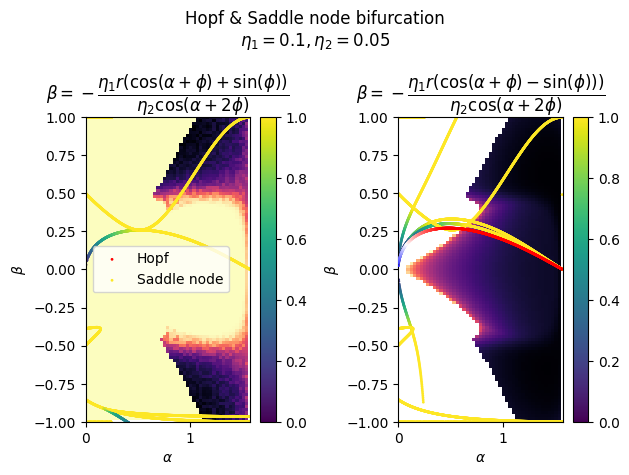

In [478]:
plt.subplot(121)

plt.pcolormesh(AL,BE,RR,cmap='magma')
plt.scatter(alpha_s_trace_p,beta_s_trace_p,s=1,c=R_s_trace_p,vmin=0,vmax=1,cmap='bwr',zorder=5,label='Hopf')
plt.scatter(alpha_s_trace_m,beta_s_trace_m,s=1,c=R_s_trace_m,vmin=0,vmax=1,cmap='bwr',zorder=5)

# plt.scatter(alpha_s_00P,beta_s_00P,s=1,c=R_s_00P,vmin=0,vmax=1,cmap='cool',zorder=3,label='0')
# plt.scatter(alpha_s_00M,beta_s_00M,s=1,c=R_s_00M,vmin=0,vmax=1,cmap='cool',zorder=3)
plt.scatter(alpha_s_pp,beta_s_pp,s=1,c=R_s_pp,vmin=0,vmax=1,label='Saddle node')
plt.scatter(alpha_s_pm,beta_s_pm,s=1,c=R_s_pm,vmin=0,vmax=1)
plt.scatter(alpha_s_mp,beta_s_mp,s=1,c=R_s_mp,vmin=0,vmax=1)
plt.scatter(alpha_s_mm,beta_s_mm,s=1,c=R_s_mm,vmin=0,vmax=1)
plt.legend()

plt.colorbar()
# plt.ylim(0,1)
plt.ylim(-1,1)

plt.xlim(0,np.pi/2)
plt.ylabel(r'$\beta$')
plt.xlabel(r'$\alpha$')
plt.title(r'$\beta=-\dfrac{\eta_1r(\cos(\alpha+\phi)+\sin(\phi))}{\eta_2\cos(\alpha+2\phi)}$')

plt.subplot(122)
plt.scatter(alpha_ms_trace_p,beta_ms_trace_p,s=1,c=R_ms_trace_p,vmin=0,vmax=1,cmap='bwr',zorder=5)
plt.scatter(alpha_ms_trace_m,beta_ms_trace_m,s=1,c=R_ms_trace_m,vmin=0,vmax=1,cmap='bwr',zorder=5)
plt.pcolormesh(AL,BE,TT,cmap='magma',norm=colors.LogNorm())



# plt.scatter(alpha_sm_00P,beta_sm_00P,s=1,c=R_sm_00P,vmin=0,vmax=1,cmap='cool',zorder=3)
# plt.scatter(alpha_sm_00M,beta_sm_00M,s=1,c=R_sm_00M,vmin=0,vmax=1,cmap='cool',zorder=3)

plt.scatter(alpha_sm_pp,beta_sm_pp,s=1,c=R_sm_pp,vmin=0,vmax=1)
plt.scatter(alpha_sm_pm,beta_sm_pm,s=1,c=R_sm_pm,vmin=0,vmax=1)
plt.scatter(alpha_sm_mp,beta_sm_mp,s=1,c=R_sm_mp,vmin=0,vmax=1)
plt.scatter(alpha_sm_mm,beta_sm_mm,s=1,c=R_sm_mm,vmin=0,vmax=1)

plt.colorbar()
plt.ylim(-1,1)
# plt.ylim(0,1)

plt.xlim(0,np.pi/2)
plt.ylabel(r'$\beta$')
plt.xlabel(r'$\alpha$')
plt.title(r'$\beta=-\dfrac{\eta_1r(\cos(\alpha+\phi)-\sin(\phi)))}{\eta_2\cos(\alpha+2\phi)}$')

# plt.title()
plt.suptitle('Hopf & Saddle node bifurcation\n'+rf'$\eta_1 = {eta1},\eta_2={eta2}$')
plt.tight_layout()

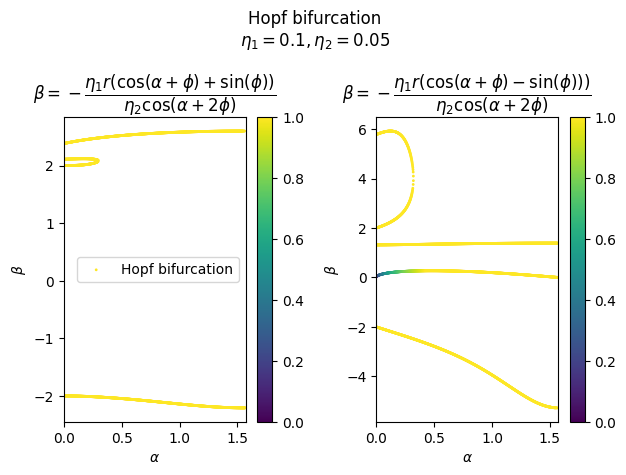

In [479]:
plt.subplot(121)

plt.scatter(alpha_s_trace_p,beta_s_trace_p,s=1,c=R_s_trace_p,vmin=0,vmax=1,label='Hopf bifurcation')
plt.scatter(alpha_s_trace_m,beta_s_trace_m,s=1,c=R_s_trace_m,vmin=0,vmax=1)

plt.legend()

plt.colorbar()
# plt.ylim(0,1)
plt.xlim(0,np.pi/2)
plt.ylabel(r'$\beta$')
plt.xlabel(r'$\alpha$')
plt.title(r'$\beta=-\dfrac{\eta_1r(\cos(\alpha+\phi)+\sin(\phi))}{\eta_2\cos(\alpha+2\phi)}$')

plt.subplot(122)
plt.scatter(alpha_ms_trace_p,beta_ms_trace_p,s=1,c=R_ms_trace_p,vmin=0,vmax=1)
plt.scatter(alpha_ms_trace_m,beta_ms_trace_m,s=1,c=R_ms_trace_m,vmin=0,vmax=1)


plt.colorbar()
# plt.ylim(0,1)
plt.xlim(0,np.pi/2)
plt.ylabel(r'$\beta$')
plt.xlabel(r'$\alpha$')
plt.title(r'$\beta=-\dfrac{\eta_1r(\cos(\alpha+\phi)-\sin(\phi)))}{\eta_2\cos(\alpha+2\phi)}$')

# plt.title()
plt.suptitle('Hopf bifurcation\n'+rf'$\eta_1 = {eta1},\eta_2={eta2}$')
plt.tight_layout()

In [527]:
eta1 = 0.1
eta2 = 0.1
alpha = 1.3
beta = 0.7
shifts = np.linspace(0,np.pi/2,20)
R2s = np.linspace(0,1,20)
t = np.arange(0,50_000,0.1)

R1X,R2Y = np.meshgrid(shifts,R2s)
r1x,r2y = R1X.flatten(),R2Y.flatten()

S_R1s,S_R2s = [],[]
TS = []


for shift,r2 in tqdm(list(zip(r1x,r2y))):
    u0 = [1,r2,shift]
    args = beta,alpha,eta1,eta2
    _,R,phi = RK4(H_Chimera,np.array(u0,dtype=float),t,args=(args,))[-200_000:].T
    S_R2s.append(R[-50_000:])
    n_freq, = np.where(np.diff(phi//(np.pi*2)))
    T = np.mean(np.diff(n_freq))*0.1
    TS.append(T)


  0%|          | 0/400 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


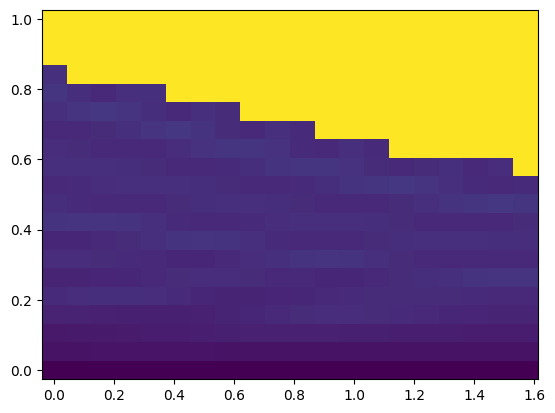

In [528]:
plt.pcolormesh(R1X,R2Y,np.array(S_R2s)[:,-1].reshape(R1X.shape))


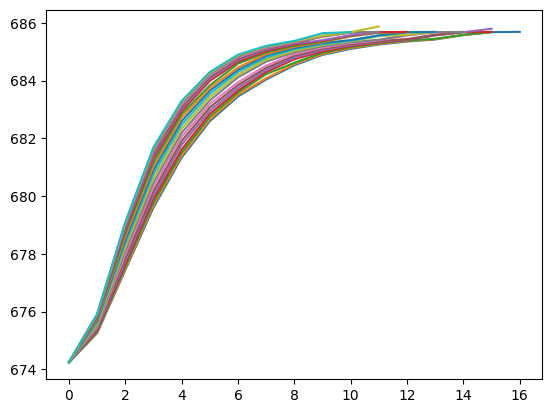

In [529]:
plt.plot(np.array(TS).reshape(R1X.shape))

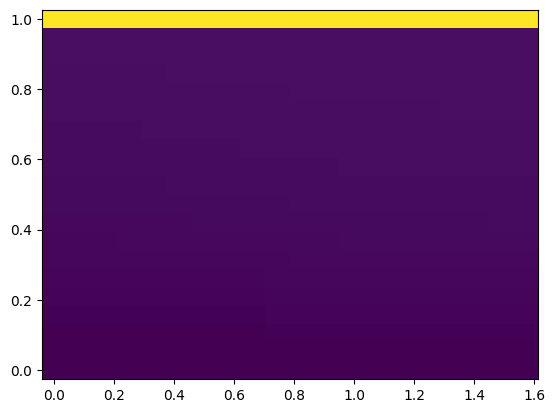

In [526]:
plt.pcolormesh(R1X,R2Y,np.array(TS).reshape(R1X.shape))

In [276]:
R1s = np.linspace(0,1,20)
R2s = np.linspace(0,1,20)

R1X,R2Y = np.meshgrid(R1s,R2s)
r1x,r2y = R1X.flatten(),R2Y.flatten()

S_R1s,S_R2s = [],[]
S_PHIS = []


for r1,r2 in tqdm(list(zip(r1x,r2y))):
    u0 = [r1,r2,0]
    u = RK4(H_Chimera,np.array(u0,dtype=float),t,args=(args,))[-50000:]
    S_R1s.append(u[:,0])
    S_R2s.append(u[:,1])
    S_PHIS.append(u[:,2])


  0%|          | 0/400 [00:00<?, ?it/s]

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2182207365.py (1)

File "../../../../../var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46697/2182207365.py", line 1:
<source missing, REPL/exec in use?> 

This error may have been caused by the following argument(s):
- argument 3: Cannot determine Numba type of <class 'tuple'>


In [177]:
R1s = np.linspace(0,1,20)
R2s = np.linspace(0,1,20)
phi_ = np.linspace(0,np.pi,20)


P1X,R2Y = np.meshgrid(phi_,R2s)
p1x,r2y = P1X.flatten(),R2Y.flatten()

S_R1s,S_R2s = [],[]
S_PHIS = []


for p,r2 in tqdm(list(zip(p1x,r2y))):
    u0 = [1,r2,p]
    u = RK4(H_Chimera,np.array(u0,dtype=float),t,args=(args,))[-50000:]
    S_R1s.append(u[:,0])
    S_R2s.append(u[:,1])
    S_PHIS.append(u[:,2])


  0%|          | 0/400 [00:00<?, ?it/s]

In [181]:
SR1 = np.array(S_R1s)
SR2 = np.array(S_R2s)
SPH = np.array(S_PHIS)

In [182]:
SSR2 = SR2[:,:].reshape(len(R1s),len(R2s),-1)
SSR1 = SR1[:,:].reshape(len(R1s),len(R2s),-1)
SSP = SPH[:,:].reshape(len(R1s),len(R2s),-1)

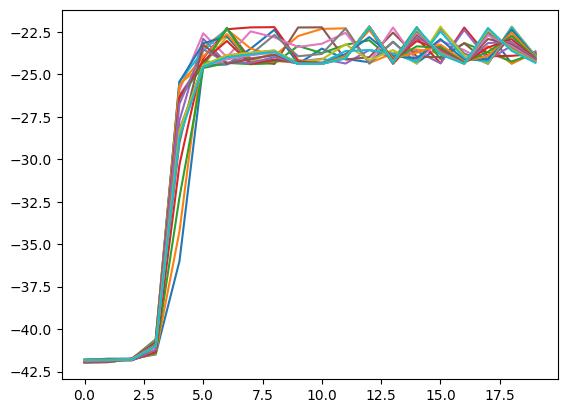

In [183]:
plt.plot(SSP[:,:,-1] - SSP[:,:,0])

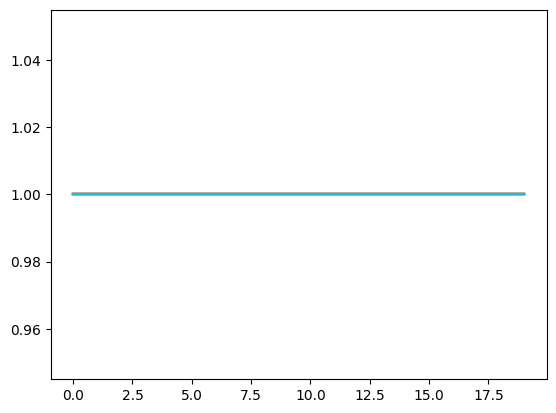

In [184]:
plt.plot(SSR1[:,:,-1])

[]

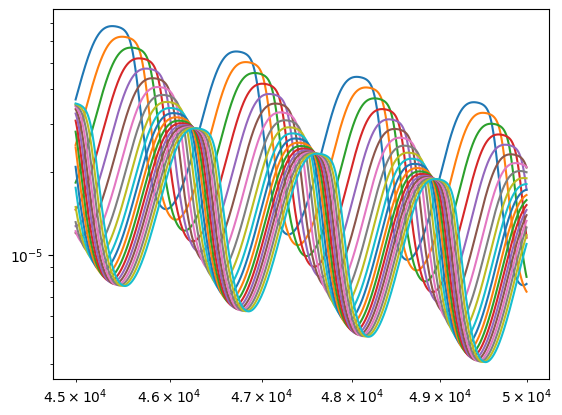

In [209]:
plt.plot(t[-50000:],1-SSR2[18,:].T);
plt.loglog()
# plt.plot(SSP[5,:].T%np.pi)


In [47]:
R1X[3]

NameError: name 'R1X' is not defined

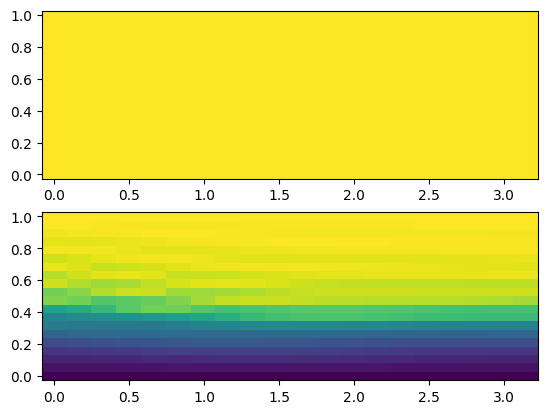

In [132]:
plt.subplot(2,1,1)
plt.pcolormesh(P1X,R2Y,SR1[:,-50].reshape(len(R1s),len(R2s)),vmin=0)
plt.subplot(2,1,2)
plt.pcolormesh(P1X,R2Y,SR2[:,-50].reshape(len(R1s),len(R2s)),vmin=0,vmax=1)

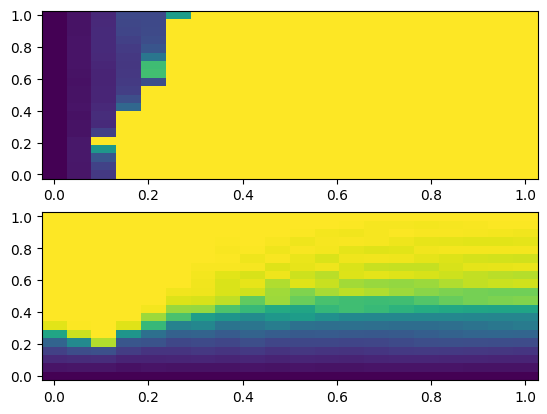

In [126]:
plt.subplot(2,1,1)
plt.pcolormesh(R1X,R2Y,SR1[:,-50].reshape(len(R1s),len(R2s)),vmin=0)
plt.subplot(2,1,2)
plt.pcolormesh(R1X,R2Y,SR2[:,-50].reshape(len(R1s),len(R2s)),vmin=0,vmax=1)

KeyboardInterrupt: 

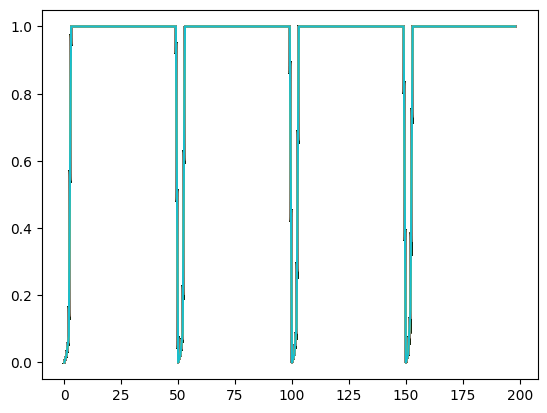

In [74]:
plt.plot()

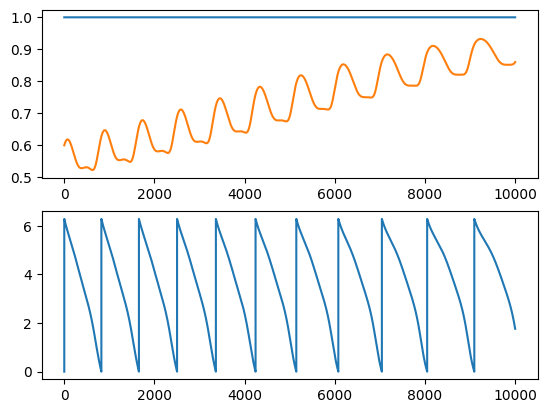

In [127]:
u0 = [1,0.6,0]
u = RK4(H_Chimera,np.array(u0,dtype=float),t,args=(args,))
plt.subplot(2,1,1)
plt.plot(t,u[:,:2])

plt.subplot(2,1,2)
plt.plot(t,u[:,2]%(np.pi*2))



In [ ]:
# beta = 0.7
# alpha = 1.2
# eta1 = 0.1
# eta2 = 0.05

alpha = 0.5
beta = 0.8
eta1 = 0.1
eta2 = 0.05

args = beta,alpha,eta1,eta2
t = np.arange(0,6000,0.1)
y = np.linspace(0,0,1)
x = np.linspace(0,2*np.pi,5)
X,Y = np.meshgrid(x,y)
fx = 0.5
fy = 0.5
# u0s = [[1-1e-3,0],[0 + 1e-3,1],[fx,fy]]
u0s = [[1,0.5,0],[0,0],[0.2,0],[0.3,0],[0.6, 0],[0.9114966199929684-0.1,3.072208206306462+0.1]]
# u0s = [[x_,y_] for x_,y_ in zip(X.flatten(),Y.flatten()) ]
plt.figure(dpi=500)
for i,u0 in enumerate(u0s):

	u = RK4(H_Chimera,np.array(u0,dtype=float),t,args=(args,))
	if i == 3:
		c = plt.scatter(u[0,0],u[0,1]%(np.pi*2),s=50,label=r'$\vec{x}^*(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))
	else:	
		c = plt.scatter(u[0,0],u[0,1]%(np.pi*2),s=50,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))
	plt.scatter(u[-1,0],u[-1,1]%(np.pi*2),s=50,marker='s',zorder=7,color=c.get_facecolor())
	plt.scatter(u[:,0],u[:,1]%(np.pi*2),s=1,alpha=0.8,zorder=6,color=c.get_facecolor())#,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))

plt.legend()
x = np.linspace(-0.1,1.2,30)
y = np.linspace(0,2*np.pi,30)
X,Y = np.meshgrid(x,y)

U,V = myFun2([X,Y],0,args)
M = (np.hypot(U,V))
# U = U / np.sqrt(U**2 + V**2);
# V = V / np.sqrt(U**2 + V**2);

# V = 0*V
xs = np.linspace(-3,-1e-5,1000)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);

# plt.axhline(0,color='black')
# plt.plot(xs,-np.log(-xs),color='black')
# plt.plot(x,xdot(x,y))
Q = plt.quiver(x,y,U,V,M,scale=20,pivot='mid',cmap='jet',zorder=3,alpha=0.7)
plt.colorbar()
plt.xlim(-0.1,1.1)
plt.ylim(0,2*np.pi)
# plt.legend()
ax =plt.gca()
xs = np.linspace(-10,10,1000)
# plt.plot(xs,F(xs))
ax.grid(True)
ax.minorticks_on()
plt.title(rf'$\alpha={alpha},\beta={beta},\eta_1={eta1},\eta_2={eta2}$')
# plt.plot(-1,0,'o',ms=10,markeredgewidth=2,markerfacecolor='white')
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)
# plt.legend()

# qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')

